In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.SIR.sir_model import *

%load_ext autoreload
%autoreload 2

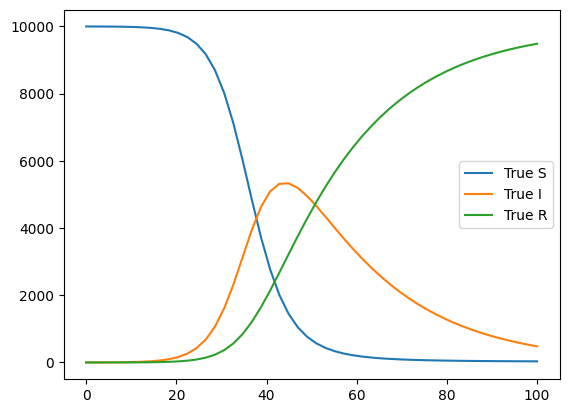

In [2]:
t = np.linspace(0, 100, 50)

S, I, R = simulate_sir(t)
plot_sir(S, I, R, t)

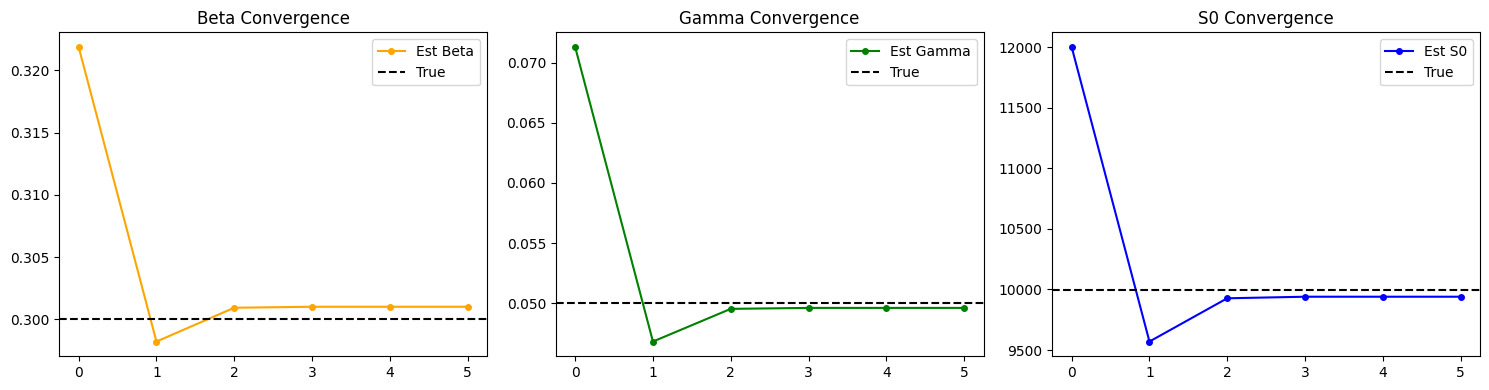

In [10]:
I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

# initial guess
beta0 = 0.1
gamma0 = 0.00003
S00 = 6000

result = run_experiments(beta0, gamma0, S00, I_data, t)
plot_results(result)

## Noise Level Analysis

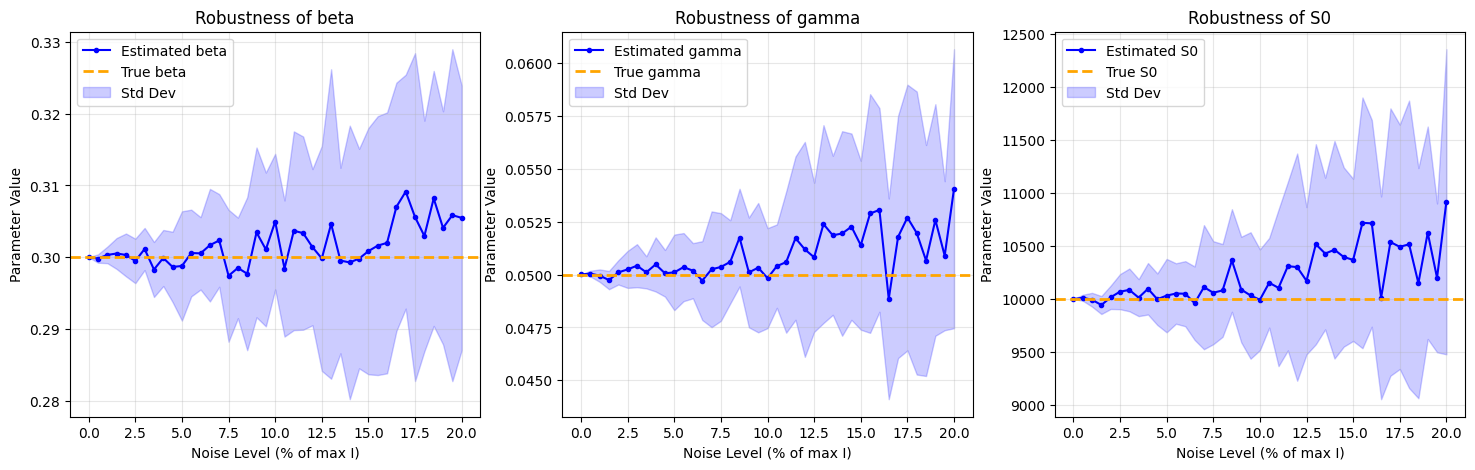

In [5]:
noise_steps = 41
noise_levels = [0.005 * i for i in range(noise_steps)]  # 0% to 20%
x_noise_percent = [0.5 * i for i in range(noise_steps)]

# initial guess for beta and gamma and S0
beta0 = 0.1
gamma0 = 0.01
S00 = 5000
x0 = [beta0, gamma0, S00]

num_of_iterations = 20

results = {
    "beta": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

for noise in noise_levels:
    beta_results = []
    gamma_results = []
    S0_results = []
    for _ in range(num_of_iterations):
        I_data = I + np.random.normal(0, noise * I, size=I.shape)

        res = least_squares(residual, x0, args=(I_data, t))

        beta_results.append(res.x[0])
        gamma_results.append(res.x[1])
        S0_results.append(res.x[2])

    results["beta"]["mean"].append(np.mean(beta_results))
    results["beta"]["std"].append(np.std(beta_results))

    results["gamma"]["mean"].append(np.mean(gamma_results))
    results["gamma"]["std"].append(np.std(gamma_results))

    results["S0"]["mean"].append(np.mean(S0_results))
    results["S0"]["std"].append(np.std(S0_results))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
params = ["beta", "gamma", "S0"]
true_values = [beta, gamma, S0]

for i, param in enumerate(params):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean
    ax.plot(x_noise_percent, means, label=f"Estimated {param}", color="blue", marker="o", markersize=3)

    # Plot True Value
    ax.axhline(y=true_values[i], label=f"True {param}", color="orange", linestyle="--", linewidth=2)

    # Plot Standard Deviation
    ax.fill_between(x_noise_percent, means - stds, means + stds, color="blue", alpha=0.2, label="Std Dev")

    ax.set_title(f"Robustness of {param}")
    ax.set_xlabel("Noise Level (% of max I)")
    ax.set_ylabel("Parameter Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Number of Datapoints

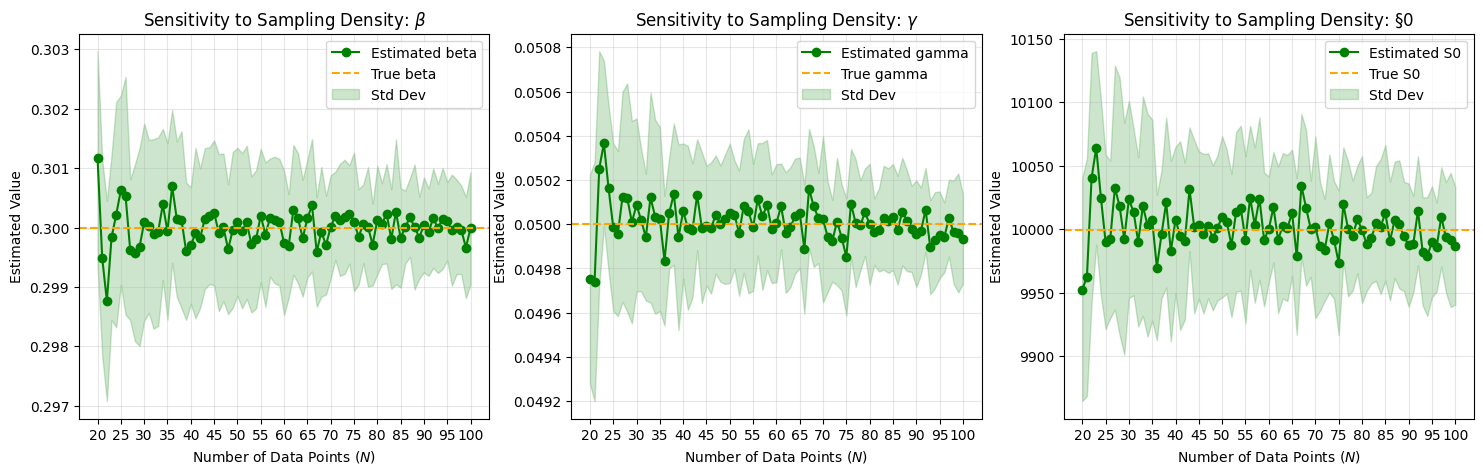

In [12]:
num_of_data_points = [1 * i for i in range(20, 101)]

results = {
    "beta": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

# initial guess for beta and gamma and S0
beta0 = 0.1
gamma0 = 0.01
S00 = 5000
x0 = [beta0, gamma0, S00]

num_of_iterations = 20

for steps in num_of_data_points:
    t = np.linspace(0, 100, steps)
    S, I, R = simulate_sir(t)

    beta_results = []
    gamma_results = []
    S0_results = []
    for _ in range(num_of_iterations):
        I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

        res = least_squares(residual, x0, args=(I_data, t))

        beta_results.append(res.x[0])
        gamma_results.append(res.x[1])
        S0_results.append(res.x[2])

    results["beta"]["mean"].append(np.mean(beta_results))
    results["beta"]["std"].append(np.std(beta_results))

    results["gamma"]["mean"].append(np.mean(gamma_results))
    results["gamma"]["std"].append(np.std(gamma_results))

    results["S0"]["mean"].append(np.mean(S0_results))
    results["S0"]["std"].append(np.std(S0_results))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
param_names = ["beta", "gamma", "S0"]
true_params = [beta, gamma, S0]

for i, param in enumerate(param_names):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean and True Value
    ax.plot(num_of_data_points, means, label=f"Estimated {param}", color="green", marker="o")
    ax.axhline(y=true_params[i], label=f"True {param}", color="orange", linestyle="--")

    # Plot Error Band
    ax.fill_between(num_of_data_points, means - stds, means + stds, color="green", alpha=0.2, label="Std Dev")

    ax.set_title(f"Sensitivity to Sampling Density: $\\{param}$")
    ax.set_xlabel("Number of Data Points ($N$)")
    ax.set_ylabel("Estimated Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.set_xticks(num_of_data_points[::5])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Simulate S0

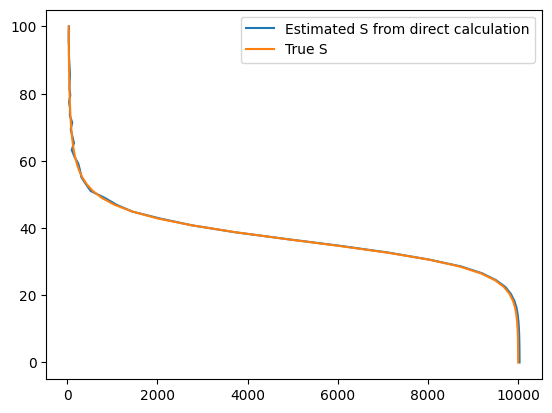

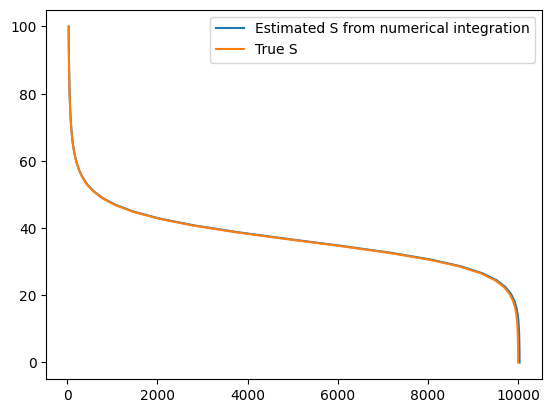

In [7]:
I_data = I + np.random.normal(0, 0.01 * I, size=I.shape)

# initial guess
beta0 = 0.1
gamma0 = 0.03
S00 = 6000
x0 = [beta0, gamma0, S00]

res = least_squares(residual, x0, args=(I_data, t))
beta_hat, gamma_hat, S0_hat = tuple(res.x)

# from the relationship equation
I_int = np.array([simpson(I_data[:i + 1], t[:i + 1]) for i in range(len(t))])
S_hat = S0_hat - I_data + I_data[0] - gamma_hat * I_int

# from numerical integration
solution_hat = scipy.integrate.odeint(SIR, [S0_hat, I_data[0], R0], t, args=(beta_hat, gamma_hat))
S_hat_2 = solution_hat.T[0]

# plot
plt.plot(S_hat, t, label="Estimated S from direct calculation")
plt.plot(S, t, label="True S")
plt.legend()
plt.show()

plt.plot(S_hat_2, t, label="Estimated S from numerical integration")
plt.plot(S, t, label="True S")
plt.legend()
plt.show()